In [1]:
import pandas as pd
import numpy as np
import random
import ruptures as rpt

import sdt
print(sdt.__version__)
from sdt.helper import numba

18.0


In [2]:
from sdt import changepoint
from sdt.changepoint import bayes_offline as offline
from sdt.changepoint import bayes_online as online
from sdt.changepoint import pelt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [1]:
def print_latex_table(df, diff_first_col=False):
    print('\\centering')
    first_col_align = 'c |' if diff_first_col else 'r'
    
    print('\\begin{{tabular}}{{ {}'.format(first_col_align), end=' ')
    num_col = df.shape[1]

    for i in range(num_col-1):
        print('| r', end=' ')
    print('}\\hline')
    
    for i in range(num_col):
        if i > 0:
            print('&', end=' ')
            print(df.columns[i], end=' ')
    print('\\\\ \\hline')
    
    for index, row in df.iterrows():
        for i in range(num_col):
            if i > 0:
                print('&', end=' ')
            col_name = df.columns[i]
            if col_name != 'Query' and col_name != 'TS':
                if row[col_name] > 0.001 or row[col_name] == 0:
                    print('{:.3f}'.format(row[col_name]).rstrip('0').rstrip('.'), end=' ')
                else:
                    sci_str = '{:.3e}'.format(row[col_name])
                    temp = sci_str.split('e-')
                    temp_front = temp[0].rstrip('0').rstrip('.')
                    temp_back = temp[1].lstrip('0')
                    
                    print('e-'.join([temp_front, temp_back]), end=' ')
            else:
                print(f'{row[col_name]}', end=' ')
        print('\\\\ \\hline')
    print('\\end{tabular}\n\\captionof{table}{}\n\\label{tab:}\n')

In [3]:
def remove_ts(df):
    return df.iloc[: , 1:]

In [4]:
# plan_mtx = pd.DataFrame([
#     ['$t_1$', 0, 50, 300, 10, 0, 5],
#     ['$t_3$', 1, 100, 500, 10, 0, 8],
#     ['$t_4$', 4, 100, 100, 0, 2, 12],
#     ['$t_6$', 2, 20, 1000, 10, 5, 4]
# ], columns=['timestamp', '$i_0$', '$i_1$', '$i_2$', '$i_3$', '$i_4$', '$i_5$'])

plan_mtx = pd.DataFrame([
    ['$q_0$', 63, 1, 0, 1],
    ['$q_1$', 9, 1, 1, 0],
    ['$q_2$', 134, 23.40, 4, 0],
], columns=['Query', '$f^i_0$', '$f^i_1$', '$f^i_2$', '$f^i_3$'])
# AvgRowSize, StatementEstRows,CompileCPU,EstimatedRowsRead

In [5]:
util_mtx = pd.DataFrame([
    ['$t_0$',32.02  ,175   , 0.070],
    ['$t_1$', 25.23 ,66    , 0.069],
    ['$t_2$', 20.65 ,35   , 0.070],
    ['$t_3$', 25.47,27  , 0.070],
], columns=['TS', '$f^j_0$', '$f^j_1$', '$f^j_2$'])
# CPU_UTILIZATION,IOPS_TOTAL, MEM_UTILIZATION, EstimateIO

In [6]:
print_latex_table(plan_mtx, True)
print_latex_table(util_mtx, True)

\centering
\begin{tabular}{ c | | r | r | r | r }\hline
& $f^i_0$ & $f^i_1$ & $f^i_2$ & $f^i_3$ \\ \hline
$q_0$ & 63 & 1 & 0 & 1 \\ \hline
$q_1$ & 9 & 1 & 1 & 0 \\ \hline
$q_2$ & 134 & 23.4 & 4 & 0 \\ \hline
\end{tabular}
\captionof{table}{}
\label{tab:}

\centering
\begin{tabular}{ c | | r | r | r }\hline
& $f^j_0$ & $f^j_1$ & $f^j_2$ \\ \hline
$t_0$ & 32.02 & 175 & 0.07 \\ \hline
$t_1$ & 25.23 & 66 & 0.069 \\ \hline
$t_2$ & 20.65 & 35 & 0.07 \\ \hline
$t_3$ & 25.47 & 27 & 0.07 \\ \hline
\end{tabular}
\captionof{table}{}
\label{tab:}



In [7]:
# horizontal concate
ndf = pd.concat([remove_ts(plan_mtx), remove_ts(util_mtx)], axis=1)
# zero padding
ndf_zero = ndf.fillna(0)
print_latex_table(ndf_zero)

\centering
\begin{tabular}{ r | r | r | r | r | r | r }\hline
& $f^i_1$ & $f^i_2$ & $f^i_3$ & $f^j_0$ & $f^j_1$ & $f^j_2$ \\ \hline
63 & 1 & 0 & 1 & 32.02 & 175 & 0.07 \\ \hline
9 & 1 & 1 & 0 & 25.23 & 66 & 0.069 \\ \hline
134 & 23.4 & 4 & 0 & 20.65 & 35 & 0.07 \\ \hline
0 & 0 & 0 & 0 & 25.47 & 27 & 0.07 \\ \hline
\end{tabular}
\captionof{table}{}
\label{tab:}



In [8]:
ndf_rem = ndf.dropna()
print_latex_table(ndf_rem)

\centering
\begin{tabular}{ r | r | r | r | r | r | r }\hline
& $f^i_1$ & $f^i_2$ & $f^i_3$ & $f^j_0$ & $f^j_1$ & $f^j_2$ \\ \hline
63 & 1 & 0 & 1 & 32.02 & 175 & 0.07 \\ \hline
9 & 1 & 1 & 0 & 25.23 & 66 & 0.069 \\ \hline
134 & 23.4 & 4 & 0 & 20.65 & 35 & 0.07 \\ \hline
\end{tabular}
\captionof{table}{}
\label{tab:}



In [9]:
# adf = pd.merge(left=plan_mtx, right=util_mtx, how='outer', on=['timestamp'], sort=True)
adf = ndf.ffill().fillna(0)
print_latex_table(adf)


\centering
\begin{tabular}{ r | r | r | r | r | r | r }\hline
& $f^i_1$ & $f^i_2$ & $f^i_3$ & $f^j_0$ & $f^j_1$ & $f^j_2$ \\ \hline
63 & 1 & 0 & 1 & 32.02 & 175 & 0.07 \\ \hline
9 & 1 & 1 & 0 & 25.23 & 66 & 0.069 \\ \hline
134 & 23.4 & 4 & 0 & 20.65 & 35 & 0.07 \\ \hline
134 & 23.4 & 4 & 0 & 25.47 & 27 & 0.07 \\ \hline
\end{tabular}
\captionof{table}{}
\label{tab:}



In [19]:
# histogram

# scaler = MinMaxScaler()
# after_scale = scaler.fit_transform(temp_np)

def freq_hist(df, bined, num_bins):
    mtx = df.to_numpy()
    for i in range(mtx.shape[1]):
        curr_list = mtx[ : , i]
        bins = np.linspace(min(curr_list), max(curr_list), num=num_bins)
        curr_col, edges = np.histogram(curr_list, bins=bins, density=True)
        bined.append(curr_col * np.diff(edges))
    return bined

num_bins = 4
bined = []
removed_plan_mtx = remove_ts(plan_mtx)
bined = freq_hist(removed_plan_mtx, bined, num_bins)

removed_util_mtx = remove_ts(util_mtx)
bined = freq_hist(removed_util_mtx, bined, num_bins)
cum_bined = np.array(bined).cumsum(axis=1)

print(np.array(bined))
hist = pd.DataFrame(np.array(cum_bined, dtype=object).T, columns=removed_plan_mtx.columns.to_list()+removed_util_mtx.columns.to_list())
print_latex_table(hist)

[[0.33333333 0.33333333 0.33333333]
 [0.66666667 0.         0.33333333]
 [0.66666667 0.         0.33333333]
 [0.66666667 0.         0.33333333]
 [0.25       0.5        0.25      ]
 [0.75       0.         0.25      ]
 [0.25       0.         0.75      ]]
\centering
\begin{tabular}{ r | r | r | r | r | r | r }\hline
& $f^i_1$ & $f^i_2$ & $f^i_3$ & $f^j_0$ & $f^j_1$ & $f^j_2$ \\ \hline
0.333 & 0.667 & 0.667 & 0.667 & 0.25 & 0.75 & 0.25 \\ \hline
0.667 & 0.667 & 0.667 & 0.667 & 0.75 & 0.75 & 0.25 \\ \hline
1 & 1 & 1 & 1 & 1 & 1 & 1 \\ \hline
\end{tabular}
\captionof{table}{}
\label{tab:}



3.5565588200778455 1
[ 502 1010]
[495, 1000]


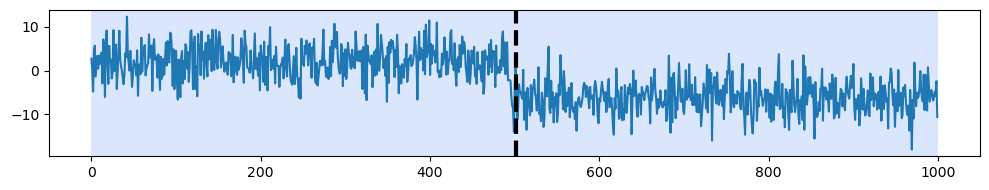

5.3182958969449885 1
[ 532 1050]
[485, 1000]


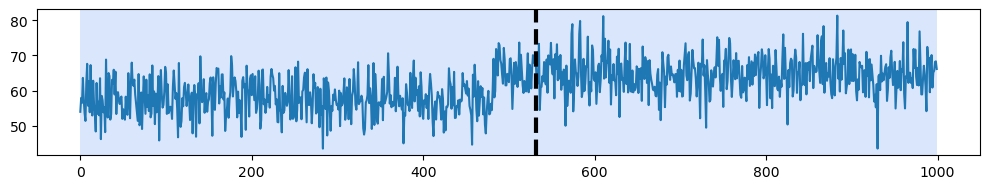

2.990697562442441 1
[ 529 1005]
[525, 1000]


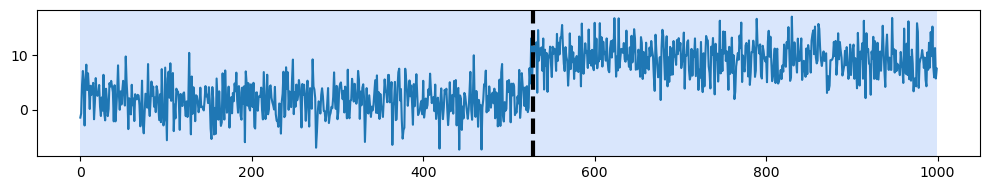

2.990697562442441 1
[ 499 1005]
[490, 1000]


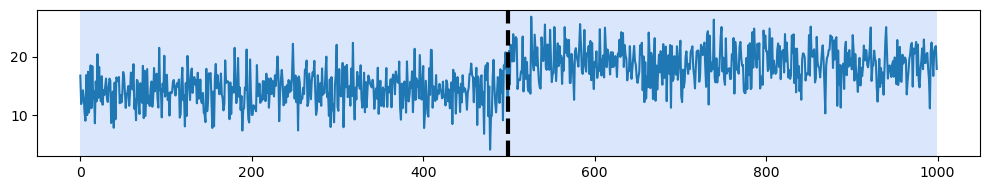

5.3182958969449885 1
[ 552 1050]
[55, 525, 1000]


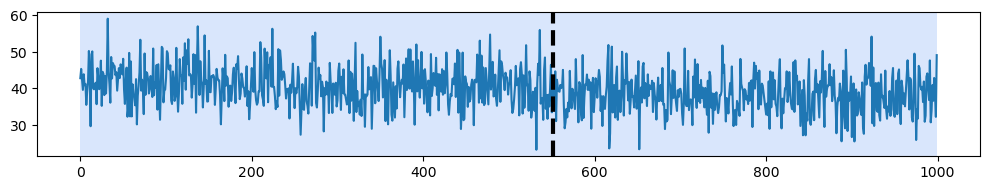

3.5565588200778455 1
[ 509 1010]
[490, 1000]


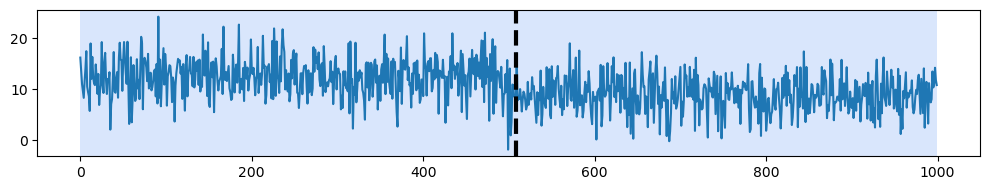

2.990697562442441 2
[ 326  668 1005]
[320, 660, 1000]


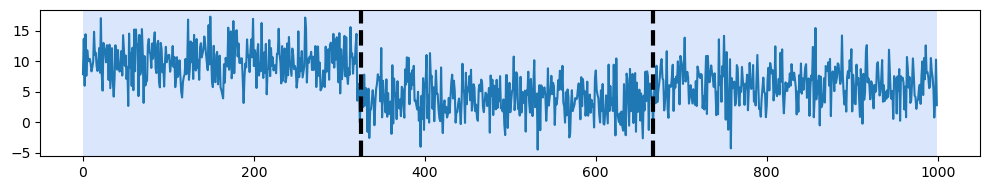

[[(2.0928165558368392, 14.339183165064188), (-6.126476761816552, 13.103378230382603)], [(58.393500429912464, 30.26893924515482), (64.71963471430203, 28.213437609718483)], [(1.806348318799648, 9.982469142139658), (9.512838438735153, 9.537369315673148)], [(14.241322491239076, 8.671856821538178), (18.916782006601913, 9.152110345495247)], [(41.11610032806232, 30.158464983432445), (38.26717708115243, 28.733892516271702)], [(12.48043160649952, 14.644011643119446), (8.87681880485323, 12.328676277127268)], [(9.857715237496874, 9.002593028438998), (3.8402509719689575, 9.155068023492136), (6.16601268292642, 8.951892801087112)]]


In [86]:
# cols = ['idx', 'stats' ,'$f_{i,0}$' ,'$f_{i,1}$', '$f_{i,2}$' ,'$f_{i,3}$', '$f_{j,0}$',  '$f_{j,1}$', '$f_{j,2}$']
cols = ['\\multicolumn{2}{c|}{Phase}' ,'$f_{i,0}$' ,'$f_{i,1}$', '$f_{i,2}$' ,'$f_{i,3}$', '$f_{j,0}$',  '$f_{j,1}$', '$f_{j,2}$']

SIZE = 7
# MAX_PERIOD = 2
MAGNITUDES = [5, 10, 50]
def bcp():
    bined=[]
    for i in range(SIZE):
        if i < 4:
            max_period = 1
        else:
            max_period = 2
        mag = MAGNITUDES[random.randint(0, len(MAGNITUDES)-1)]
        n_samples, dim, sigma = 1000, 1, 2*np.sqrt(np.sqrt(mag))
        n_bkps = random.randint(0, max_period)
        print(sigma, n_bkps)
        curr_list, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma, delta=(1, 10))
        
        if mag == 1:
            mag = 10
        curr_list = np.array(curr_list) + mag
        bkps = np.array(bkps) + mag
        print(bkps)
        algo = rpt.Pelt(model="rbf").fit(curr_list)
        result = algo.predict(pen=3)
        print(result)
        # rpt.display(curr_list, [len(curr_list)], result)
        rpt.display(curr_list, [len(curr_list)], bkps)
        plt.show()
        # for each range in result, calculate the stats
        start = 0
        curr_stats_list = []
        for end in bkps:
            curr_period = curr_list[start:end]
            v = curr_period.var()
            m = curr_period.mean()
            curr_stats_list.append((m, v))
            start = end
        bined.append(curr_stats_list)
    return bined
bined = bcp()
print(bined)

3.1622776601683795
[]


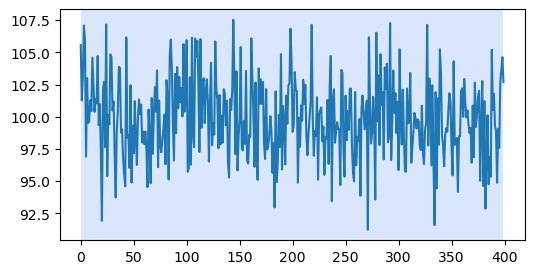

3.1622776601683795
[]


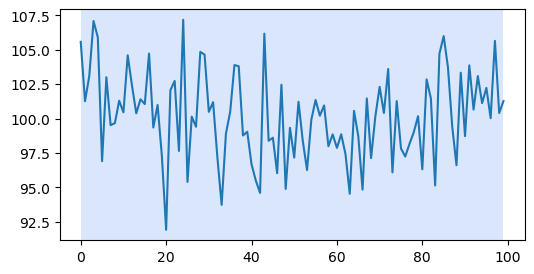

3.1622776601683795
[]


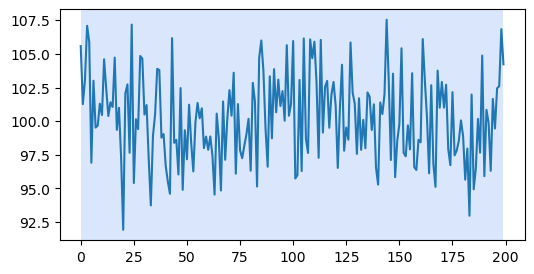

2.6591479484724942
[]


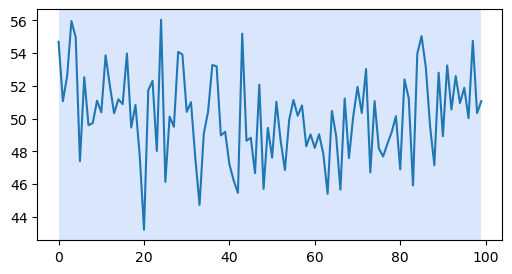

1.7782794100389228
[]


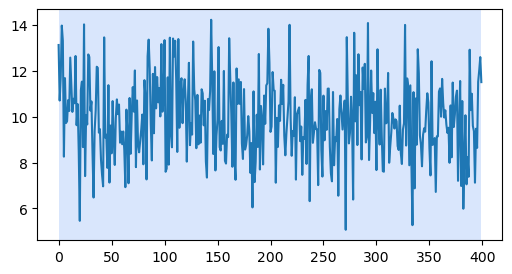

3.1622776601683795
1.7782794100389228
[400]


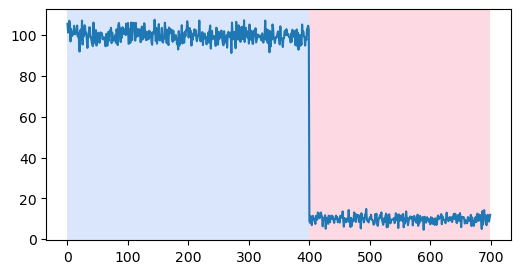

1.7782794100389228
2.6591479484724942
[200]


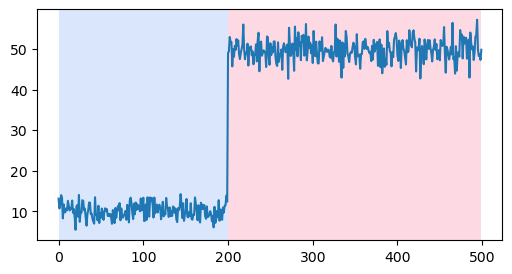

In [83]:
# cols = ['idx', 'stats' ,'$f_{i,0}$' ,'$f_{i,1}$', '$f_{i,2}$' ,'$f_{i,3}$', '$f_{j,0}$',  '$f_{j,1}$', '$f_{j,2}$']
cols = ['\\multicolumn{2}{c|}{Phase}' ,'$f_{i,0}$' ,'$f_{i,1}$', '$f_{i,2}$' ,'$f_{i,3}$', '$f_{j,0}$',  '$f_{j,1}$', '$f_{j,2}$']

SIZE = 7
# MAX_PERIOD = 2
MAGNITUDES = [10, 50, 100]
# det = offline.BayesOffline("const", "gauss")
det = online.BayesOnline('const', 'student_t', engine="python")#, {"time_scale": 0})
resource_phases = [0, 1, 1]
np.random.shuffle(resource_phases)

def bcp():
    bined=[]
    for i in range(SIZE):
        if i < 4:
            n_bkps = 0
        else:
            n_bkps = resource_phases[i-4]
        np.random.shuffle(MAGNITUDES)

        rand_state = np.random.RandomState(0)
        data = []
        for j in range(n_bkps+1):
            mag = MAGNITUDES[j]
            curr_std = np.sqrt(np.sqrt(mag))
            print(curr_std)
            num_data = random.randint(1, 5)*100
            curr = rand_state.normal(mag, curr_std, num_data)
            data = np.append(data, curr)
        curr_list = np.array(data)
        fig, ax = plt.subplots(figsize=(6, 3))
        result = det.find_changepoints(curr_list, prob_threshold=0.1)
        print(result)
        changepoint.plot_changepoints(curr_list, result, ax=ax)
        plt.show()
        result = np.append(result, len(curr_list))
        # for each range in result, calculate the stats
        start = 0
        curr_stats_list = []
        for end in result:
            curr_period = curr_list[start:end]
            v = curr_period.var()
            m = curr_period.mean()
            curr_stats_list.append((m, v))
            start = end
        bined.append(curr_stats_list)
    return bined
bined = bcp()

In [84]:
print(bined)
# print(np.array(bined).shape)
print('\\centering')
first_col_align = 'c | c |'

print('\\begin{{tabular}}{{ {}'.format(first_col_align), end=' ')
num_col = len(bined)

for i in range(SIZE):
    print('| r', end=' ')
print('}\\hline')

for i in range(len(cols)):
    if i > 0:
        print('&', end=' ')
    print(cols[i], end=' ')
print('\\\\ \\hline')

num_rows = np.max([len(ls) for ls in bined])

for index in range(num_rows):
    print('\\multirow{{2}}{{*}}{{{}}}'.format(index), end=' ')
    print('& $\\mu$', end=' ')
    for i in range(SIZE):
        fill = 0 if index >= len(bined[i]) else bined[i][index][0]
        print(' & {:.2f}'.format(fill).rstrip('0').rstrip('.'), end=' ')
    print('\\\\ \\cline{{2-{}}}'.format(SIZE+2))
    print('& $\\sigma^2$', end=' ')
    for i in range(SIZE):
        fill = 0 if index >= len(bined[i]) else bined[i][index][1]
        print(' & {:.2f}'.format(fill).rstrip('0').rstrip('.'), end=' ')
    print('\\\\ \\hline')
print('\\end{tabular}\n\\captionof{table}{}\n\\label{tab:}\n')


[[(99.90971066340742, 9.76413000811805)], [(100.18912955142372, 10.158266192149314)], [(100.22423866833182, 10.43304472410593)], [(50.159038361810744, 7.182978909566827)], [(9.949226574809973, 3.0876890195651403)], [(99.90971066340742, 9.76413000811805), (9.792270393920331, 3.3041784525281845)], [(10.126098669908632, 3.299218425857775), (49.76192366286649, 6.750715501091435)]]
\centering
\begin{tabular}{ c | c | | r | r | r | r | r | r | r }\hline
\multicolumn{2}{c|}{Phase} & $f_{i,0}$ & $f_{i,1}$ & $f_{i,2}$ & $f_{i,3}$ & $f_{j,0}$ & $f_{j,1}$ & $f_{j,2}$ \\ \hline
\multirow{2}{*}{0} & $\mu$  & 99.91  & 100.19  & 100.22  & 50.16  & 9.95  & 99.91  & 10.13 \\ \cline{2-9}
& $\sigma^2$  & 9.76  & 10.16  & 10.43  & 7.18  & 3.09  & 9.76  & 3.3 \\ \hline
\multirow{2}{*}{1} & $\mu$  & 0  & 0  & 0  & 0  & 0  & 9.79  & 49.76 \\ \cline{2-9}
& $\sigma^2$  & 0  & 0  & 0  & 0  & 0  & 3.3  & 6.75 \\ \hline
\end{tabular}
\captionof{table}{}
\label{tab:}



In [13]:
# def bcp(df, bined):
#     mtx = df.to_numpy()
#     for i in range(mtx.shape[1]):
#         curr_list = mtx[ : , i]
#         algo = rpt.Pelt(model="rbf").fit(curr_list)
#         result = algo.predict(pen=0)
#         # rpt.display(curr_list, [len(curr_list)], result)
#         plt.show()
#         print(result)
#         # for each range in result, calculate the stats
#         start = 0
#         curr_stats_list = []
#         for end in result:
#             curr_period = curr_list[start:end]
#             v = curr_period.var()
#             m = curr_period.mean()
#             curr_stats_list.append((m, v))
#         bined.append(curr_stats_list)
#     return bined

In [14]:
# num_bins = 4
# bined = []
# removed_plan_mtx = remove_ts(plan_mtx)
# bined = bcp(removed_plan_mtx, bined)
# removed_util_mtx = remove_ts(util_mtx)
# bined = bcp(removed_util_mtx, bined)

# print(bined)
# hist = pd.DataFrame(np.array(bined, dtype=object).T, columns=removed_plan_mtx.columns.to_list()+removed_util_mtx.columns.to_list())
# hist

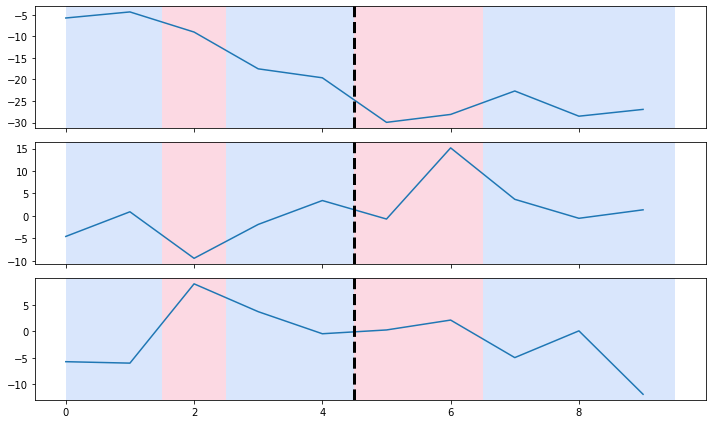

[ -5.72873419  -4.31652998  -8.99283082 -17.5337347  -19.61233007
 -29.96118798 -28.1199404  -22.67773276 -28.52925549 -26.94947634]
[5, 10]


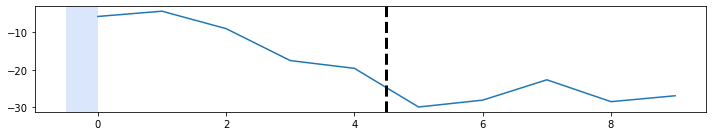

In [15]:
# generate signal
n_samples, dim, sigma = 10, 3, 4
n_bkps = 4  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

# signal = signal[ : , 0]
# print(signal)
# detection
algo = rpt.Pelt(model="rbf").fit(signal)
result = algo.predict(pen=0)

# display
rpt.display(signal, bkps, result)
plt.show()

signal = signal[ : , 0]
print(signal)
# detection
algo = rpt.Pelt(model="rbf").fit(signal)
result = algo.predict(pen=0)
print(result)

# display
rpt.display(signal, [0], result)
plt.show()